In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, UpSampling2D
from keras.metrics import BinaryAccuracy
from keras.models import Model

from sklearn.neighbors import NearestNeighbors

import cv2
import os
import numpy as np
from imutils import build_montages

from google.colab.patches import cv2_imshow

In [ ]:
!mkdir /content/images
!mkdir /content/images/train
!mkdir /content/images/test
!mkdir /content/labels
!mkdir /content/labels/train
!mkdir /content/labels/test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/NATO/train.zip' -d '/content/images/train'
!unzip '/content/drive/My Drive/NATO/train_l.zip' -d '/content/labels/train'
!unzip '/content/drive/My Drive/NATO/test.zip' -d '/content/images/test'
!unzip '/content/drive/My Drive/NATO/test_l.zip' -d '/content/labels/test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/labels/train/img48014.txt  
  inflating: /content/labels/train/img48015.txt  
  inflating: /content/labels/train/img48016.txt  
  inflating: /content/labels/train/img48017.txt  
  inflating: /content/labels/train/img48018.txt  
  inflating: /content/labels/train/img48019.txt  
  inflating: /content/labels/train/img48020.txt  
  inflating: /content/labels/train/img48021.txt  
  inflating: /content/labels/train/img48022.txt  
  inflating: /content/labels/train/img48023.txt  
  inflating: /content/labels/train/img48024.txt  
  inflating: /content/labels/train/img48025.txt  
  inflating: /content/labels/train/img48026.txt  
  inflating: /content/labels/train/img48027.txt  
  inflating: /content/labels/train/img48028.txt  
  inflating: /content/labels/train/img48029.txt  
  inflating: /content/labels/train/img48030.txt  
  inflating: /content/labels/train/img48031.txt  
  inflating: /content/labels/train/img48032.txt  

In [ ]:
Dict = {1: 'attack'}
Dict_images = {key: [] for key in Dict.values()}
Dict_images_test = {key: [] for key in Dict.values()}

In [ ]:
images = '/content/images/train'
labels = '/content/labels/train'

file_list = os.listdir(images)

for name in file_list:
    tmp_list_class = []
    image = cv2.imread(images+"/"+name, cv2.IMREAD_GRAYSCALE)
    with open(labels+"/"+str(name).split(".")[0]+".txt") as f:
        lines = [line.rstrip('\n') for line in f]
        for line in lines:
            x = int((float(line.split(" ")[1])-(float(line.split(" ")[3])/2)) * 770)
            y = int((float(line.split(" ")[2])-(float(line.split(" ")[4])/2)) * 576)
            w = int(float(line.split(" ")[3]) * 770 + 5)
            h = int(float(line.split(" ")[4]) * 576 + 5)

            crop_image = image[y:y+h, x:x+w]
            tmp_list_class.append(int(line.split(" ")[0]))
            dim = (120, 120)
            resized_img = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA)
            try:
                Dict_images[Dict[int(line.split(" ")[0])]].append(resized_img)
            except KeyError:
                pass

In [ ]:
images = '/content/images/test'
labels = '/content/labels/test'

file_list = os.listdir(images)

for name in file_list:
    tmp_list_class = []
    image = cv2.imread(images+"/"+name, cv2.IMREAD_GRAYSCALE)
    with open(labels+"/"+str(name).split(".")[0]+".txt") as f:
        lines = [line.rstrip('\n') for line in f]
        for line in lines:
            x = int((float(line.split(" ")[1])-(float(line.split(" ")[3])/2)) * 770)
            y = int((float(line.split(" ")[2])-(float(line.split(" ")[4])/2)) * 576)
            w = int(float(line.split(" ")[3]) * 770 + 5)
            h = int(float(line.split(" ")[4]) * 576 + 5)

            crop_image = image[y:y+h, x:x+w]
            tmp_list_class.append(int(line.split(" ")[0]))
            dim = (120, 120)
            resized_img = cv2.resize(crop_image, dim, interpolation = cv2.INTER_AREA)
            try:
                Dict_images_test[Dict[int(line.split(" ")[0])]].append(resized_img)
            except KeyError:
                pass

In [ ]:
x_train = np.array(Dict_images["attack"])
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

x_test = np.array(Dict_images_test["attack"])
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print(x_train.shape, x_test.shape)

(14812, 120, 120, 1) (464, 120, 120, 1)


In [ ]:
# autoencoder model
# encoder
input = Input(shape=(120, 120, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size=(2, 2), padding='same', name="encoded")(x)
#decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(inputs=input, outputs=decoded)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        18496 

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(x_train, x_train, batch_size = 64, epochs = 50, validation_data=(x_test, x_test))

Epoch 1/50
232/232 [==============================] - 19s 41ms/step - loss: 0.1590 - accuracy: 0.6480 - val_loss: 0.1017 - val_accuracy: 0.6615
Epoch 2/50
232/232 [==============================] - 9s 37ms/step - loss: 0.0890 - accuracy: 0.6630 - val_loss: 0.0981 - val_accuracy: 0.6621
Epoch 3/50
232/232 [==============================] - 9s 37ms/step - loss: 0.0842 - accuracy: 0.6638 - val_loss: 0.0888 - val_accuracy: 0.6640
Epoch 4/50
232/232 [==============================] - 9s 37ms/step - loss: 0.0815 - accuracy: 0.6642 - val_loss: 0.0867 - val_accuracy: 0.6644
Epoch 5/50
232/232 [==============================] - 9s 37ms/step - loss: 0.0798 - accuracy: 0.6645 - val_loss: 0.0852 - val_accuracy: 0.6647
Epoch 6/50
232/232 [==============================] - 9s 38ms/step - loss: 0.0787 - accuracy: 0.6646 - val_loss: 0.0841 - val_accuracy: 0.6649
Epoch 7/50
232/232 [==============================] - 9s 37ms/step - loss: 0.0777 - accuracy: 0.6648 - val_loss: 0.0834 - val_accuracy: 0.665

In [ ]:
model.save("autoencoder.h5")

15/15 [==============================] - 0s 6ms/step


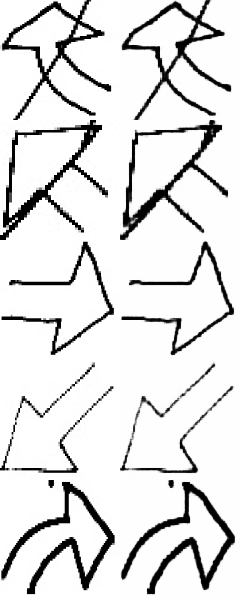

In [ ]:
decoded = model.predict(x_test)

examples = []
for i in range(5):
    original = x_test[i] * 255
    decoded_img = decoded[i] * 255
    comparison = np.hstack([original, decoded_img])
    examples.append(comparison)

comparsion_images = np.vstack(examples)
cv2_imshow(comparsion_images)

In [ ]:
encoder = Model(inputs=model.input, outputs=model.get_layer("encoded").output)

features = encoder.predict(x_train)
indexes = list(range(0, x_train.shape[0]))
data = {"indexes": indexes, "features": features}

463/463 [==============================] - 1s 3ms/step


In [ ]:
predicted = encoder.predict(x_test)

15/15 [==============================] - 0s 5ms/step


## Find similarity

In [ ]:
number_of_images = list(range(0, x_test.shape[0]))
random_images = np.random.choice(number_of_images, size=5, replace=False)

## Euclidean distance

In [ ]:
def euclidean(x, y):
	return np.linalg.norm(x - y)
 
def search(fFeatures, data):
    results = []
    for i in range(0, len(data["features"])):
        distance = euclidean(features, data["features"][i])
        results.append((d, i))
    results = sorted(results)[:5]
    return results

Original


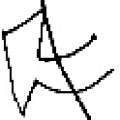

Similar symbols
[32.432358, 32.837246, 33.03739, 33.140728, 33.198437]


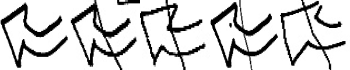

Original


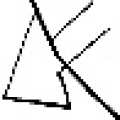

Similar symbols
[28.320223, 29.642754, 30.500145, 30.531935, 30.652458]


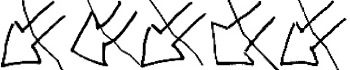

Original


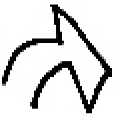

Similar symbols
[32.04967, 32.436604, 32.65589, 32.91945, 33.33064]


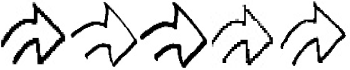

Original


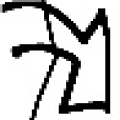

Similar symbols
[34.262146, 34.51396, 34.737854, 35.130505, 35.175934]


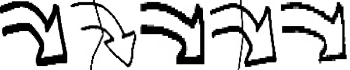

Original


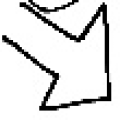

Similar symbols
[28.303106, 28.944536, 29.783468, 29.907753, 30.425764]


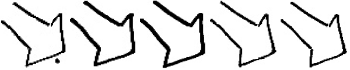

In [ ]:
for i in random_images:
    features_pred = predicted[i]
    results = search(features_pred, data)
    images = []
    distances = []
    for (distance, index) in results:
        distances.append(distance)
        image = (x_train[index] * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)
    query = (x_test[i] * 255).astype("uint8")
    print("Original")
    cv2_imshow(query)
    montage = build_montages(images, (70, 70), (5, 1))[0]
    print("Similar symbols")
    print(distances)
    cv2_imshow(montage)


## KNN (Cosine)

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
features_reshape = features.reshape((-1, np.prod((features.shape[1:]))))
knn.fit(features_reshape)

NearestNeighbors(metric='cosine')

Original


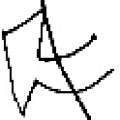

Similar symbols
[[0.1737417  0.18541813 0.18598503 0.18852538 0.1904459 ]]


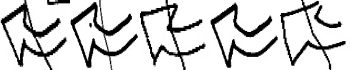

Original


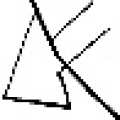

Similar symbols
[[0.14511406 0.16070276 0.16808516 0.16836977 0.16868854]]


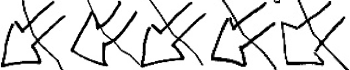

Original


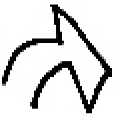

Similar symbols
[[0.17856246 0.1861887  0.19065505 0.19148648 0.1940341 ]]


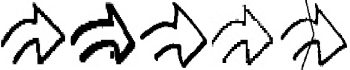

Original


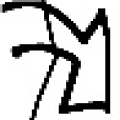

Similar symbols
[[0.1741429  0.18078387 0.1849584  0.18841761 0.18965262]]


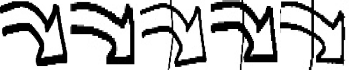

Original


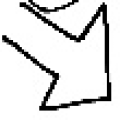

Similar symbols
[[0.15303397 0.15729433 0.16415024 0.16725749 0.16793108]]


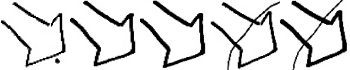

In [ ]:
predicted_reshape = predicted.reshape((-1, np.prod((predicted.shape[1:]))))

for i in random_images:
    distances, indices = knn.kneighbors([predicted_reshape[i]])
    results = [x_train[idx] for idx in indices.flatten()]
    images = []
    for index in results:
        image = (index * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)
    query = (x_test[i] * 255).astype("uint8")
    print("Original")
    cv2_imshow(query)
    montage = build_montages(images, (70, 70), (5, 1))[0]
    print("Similar symbols")
    print(distances)
    cv2_imshow(montage)

## KNN (Euclidean)

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
features_reshape = features.reshape((-1, np.prod((features.shape[1:]))))
knn.fit(features_reshape)

NearestNeighbors(metric='euclidean')

Original


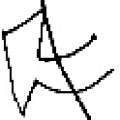

Similar symbols
[[32.432358 32.837246 33.037395 33.14073  33.198437]]


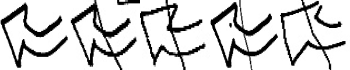

Original


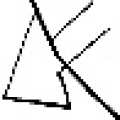

Similar symbols
[[28.320223 29.642754 30.500147 30.531939 30.652456]]


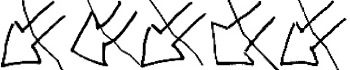

Original


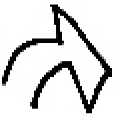

Similar symbols
[[32.04967  32.436607 32.65589  32.91945  33.33064 ]]


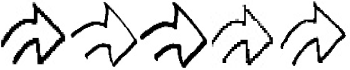

Original


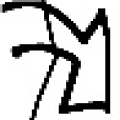

Similar symbols
[[34.262146 34.51396  34.737854 35.130505 35.175934]]


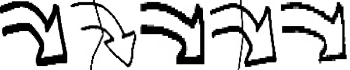

Original


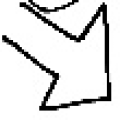

Similar symbols
[[28.303108 28.944534 29.78347  29.907755 30.425768]]


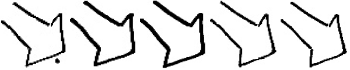

In [ ]:
predicted_reshape = predicted.reshape((-1, np.prod((predicted.shape[1:]))))

for i in random_images:
    distances, indices = knn.kneighbors([predicted_reshape[i]])
    results = [x_train[idx] for idx in indices.flatten()]
    images = []
    for index in results:
        image = (index * 255).astype("uint8")
        image = np.dstack([image] * 3)
        images.append(image)
    query = (x_test[i] * 255).astype("uint8")
    print("Original")
    cv2_imshow(query)
    montage = build_montages(images, (70, 70), (5, 1))[0]
    print("Similar symbols")
    print(distances)
    cv2_imshow(montage)